# Implementing a Neural Network From Scratch
### This notebook is a personal exercise in implementing a Neural Netowork from scratch (i.e., no frameworks).
### I intend to explain as many of specifics as I can, primarily to educate myself, and secondarily to anyone who views this.

# Part 1 - Importing, Exploring, and Preparing the Data
### This notebook uses the MNIST dataset to classify hand-written digits. Typically image classification is done with Convolutional Neural Networks, but these images are simple enough that processing with a standard neural network is feasible.

In [72]:
# Load the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist # This is the dataset, not using any frameworks in this notebook.


In [2]:
# Load the Data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_tr, Y_tr, X_tst, Y_tst = X_train, Y_train, X_test, Y_test

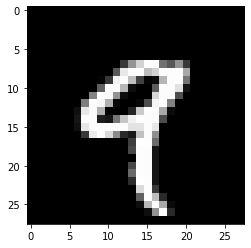

    This image is labeled as a "9"



In [3]:
# Visualize an Example, any example
ex_img = 4
image = X_train[ex_img]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()
print(f'    This image is labeled as a "{Y_train[ex_img]}"\n')

In [4]:
# Learn about the data
print(f'Each image is of type: {type(image)}\n')
print(f'Each image is of size: {np.shape(image)}\n')
print(f'There are {len(X_train)} example images in X_train, with {len(Y_train)} labels.\n')
print(f'X_train is of shape {np.shape(X_train)} and Y_train is of shape {np.shape(Y_train)}.\n')
print(f'The minimum value in an array is {np.min(X_train)}, while the max is {np.max(X_train)}. (Typical for color values)')

Each image is of type: <class 'numpy.ndarray'>

Each image is of size: (28, 28)

There are 60000 example images in X_train, with 60000 labels.

X_train is of shape (60000, 28, 28) and Y_train is of shape (60000,).

The minimum value in an array is 0, while the max is 255. (Typical for color values)


In [5]:
# Flatten each of the images so each image is a single row (i.e, the array will be of shape (60,000, 28x28)).
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)
print(f'The array of flattened images is of shape {np.shape(X_test)}.\n')

The array of flattened images is of shape (10000, 784).



### Data should be standardized or normalized before it can be processed. There are many different methods depending on the type of data. Here, since the values range from 0 to 255, dividing all values by 255 will ensure that all values are between 0 and 1.

In [6]:
X_train = X_train / 255
X_test = X_test / 255
# transpose this matrix so it will be able to be used in a dot-product
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

### Converting the labels to one-hot encoded vectors is necessary for the Cost Function

In [7]:
# Turn each value of the labels into a one-hot vector and transpose.
Y_train_oh = np.zeros((np.shape(Y_train)[0], np.max(Y_train) + 1))
Y_train_oh[np.arange(len(Y_train)), Y_train] = 1
Y_train_oh = np.transpose(Y_train_oh)

Y_test_oh = np.zeros((np.shape(Y_test)[0], np.max(Y_test) + 1))
Y_test_oh[np.arange(len(Y_test)), Y_test] = 1
Y_test_oh = np.transpose(Y_test_oh)

# Transpose matrix
print(f'The shape of "y_train_oh" is {np.shape(Y_train_oh)}.\n')
print('The first several one-hot encode vectors are printed below:\n')
print(Y_train_oh[:, 0:20])


The shape of "y_train_oh" is (10, 60000).

The first several one-hot encode vectors are printed below:

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Part 2 - Initializing the Parameters and Network Architecture

### I will be creating a Neural Network with 2 hidden layers, which means there will be 3 layers when the output layer is included. Apparently by convention, the input layer does not count as a "layer", but I will define it as layer "0". The the two hidden layers can have any number of nodes (within reason). The final layer will have 10 nodes, which is chosen since there are 10 output classes (10 digits, 0-9).

### Here I create a function that initializes the weight and bias parameters 
#### Random initialization is necessary for the weights in order to "break symmetry". Without this, each node will be computing "0", meaning no node will be favored by the network over others, and the network will be "learning" nothing.
#### Learning Note: I learned from this experience that initialization is more important than I originally conceived. First, I used np.random.rand, which initializes with numbers between 0 and 1. This creates problems later in the process, as computation values will explode, and quickly become unworkable (python starts returning 'nan'). I switched to using np.random.randn, which uses a normal distribution to initialize. I also included a scaling factor, which makes my initialization a method called "He Initialization". This works if reLU is used for the activation function.

In [8]:
def initialize_parameters(nodes):
    """Initialize the weight matrices and bias vectors"""
    """
    Inputs: 
            nodes: vector with the number of nodes in layer[i]
            
    Outputs:
            Weights array - array of arrays that hold the weight values for each layer
            Bias array - array of vectors that hold the bias values for each layer
    """
    
        # initialize vector to hold weights and bias
    layer_weights = []
    layer_biases = []
        
        # Loop through 'nodes' to initialize the weights and biases in layer[i]
    for i in range(len(nodes)):
        if i == 0: # No weights are needed for layer "0" - this is my way of making sure that weights[i] correspond with layer[i]
            weights = 'NaN'
            b = 'NaN'
        else:
            # randn should be used, as this creates positive and negative starting weights
            # This method (particularly the multiplying of the square root) is called "He Initialization"
            # It is known to work well for reLU activation.
            weights = np.random.randn(nodes[i], nodes[i-1]) * np.sqrt(2 / nodes[i-1])       
            b = np.zeros((nodes[i], 1))
            
        layer_weights.append(weights)
        layer_biases.append(b)
         
    return layer_weights, layer_biases
                

# Part 3 - Activation Functions
### Activation functions are a crucial part of a neural network. They introduce non-linearities into the model. These non-linearities are what allow the neural network to fit to non-linear curves, which is what makes them useful. There are many activation functions, each of which have their proper use cases. Here, I use ReLU for the hidden layers, and Softmax for the output layer.

### ReLU Activation
#### ReLU activation (Rectified Linear Unit) is a function that takes as input the result of $z = wx + b$, (weights multiplied by inputs with an added bias layer) and returns either the value of $z$ or $0$, whichever is greater. This has become the go-to activation function for hidden layers.

In [9]:
def reLU(matrix):
    """ Computes the reLU activation elementwise on the matrix"""
    """Input: a numpy array
       Output: the reLu activation applied to each element"""
        
    matrix = np.maximum(0, matrix) # Choose between the matrix element, or 0, whichever is greater
    
    return matrix


### Softmax Activation
#### Softmax Activation is a function that is used on the output layer of multi-class classification applications. The purpose is to return a relative probability with respect to every other class. This means that the sum of the results of softmax equals 1. This means that the prediction of the output class is the index of value with the highest number. 

In [10]:
def softmax(array):
    """Computes the softmax value elementwise in an array"""
    """Input: a numpy array
       Output: a numpy array of the same size as Input"""
    
    soft_array = np.exp(array) / np.sum(np.exp(array), axis=0) # axis=0 indicates summing over rows (summing all the elements in a column)
    
    return soft_array

# Part 4  - Forward Propagation

### Forward propagation is the algorithm that takes an input, runs it through the network and makes a prediction. There is a basic form of this algorithm that operates on a single layer, and the output is passed as input to the subsequent layer. Here I implement a forward propagation for a single layer.

$$Z = Wx + b$$
$$A = f(Z)$$
#### Where f(x) is the activation function

In [11]:
def forward_propagation(weights, bias, layer_input, activation='relu'):
    """Implements a single step of forward propagation"""
    """Inputs
            weights: array of weights for this layer
            bias: vector of bias values for this layer
            layer_input: the input to this layer
            activation_function: the activation to be used on this layer - 'relu' by default
       Outputs
            Z: the result of Wx + b (needed for back propagation)
            activation: The activated result of Wx + b"""
    
    Z = np.dot(weights, layer_input) + bias
    
    if activation == 'relu':
        A = reLU(Z)
    elif activation == 'softmax':
        A = softmax(Z)
        
    return A , Z
    
    

In [12]:
nodes = [np.shape(X_train)[0], 30, 20, 10]
weights, biases = initialize_parameters(nodes)
A1, Z1 = forward_propagation(weights[1], biases[1], X_train, activation='relu')
A2, Z2 = forward_propagation(weights[2], biases[2], A1, activation='relu')
A3, Z3 = forward_propagation(weights[3], biases[3], A2, activation='softmax')

# Part 5 - Cost Function
### The cost function is a function that sums the differences between every value the model predicts, and its true value. It is this cost function we are trying to minimize. When the predictions are really small, the cost value will also be small. I use a function called categorical cross entropy. The total function (summed over all examples) is defined as follows:

$$ J = -(1/m)\Sigma_{j=0}^{M}\Sigma_{i=0}^{N}(y_{i} * log(a_{ij}))$$

Where M = Number of examples and N = Number of classes

In [13]:
def cross_entropy_cost(y_true, y_predicted):
    """Calculate the cross entropy loss"""
    """Inputs
            y_true: Array of the true labels
            y_predicted: Array of the predicted labels
            
       Outputs
               J: the cross entropy loss (a single value)"""
    
    # Find the number of examples
    m = np.shape(y_true)[1]
    # Calculate the log of y_predicted
    log_y_pred = np.log(y_predicted)
    
    # Multiply by the true labels
    product = y_true * log_y_pred
    
    # sum across rows and columns
    J = -np.sum(product)
    
    return J / m
    
       

# Part 6 - Backpropagation

### Backpropagation is the the heart and soul of a Neural Network. Backpropagation is the process by which the weights and biases are determined. 

## The Math

### For a single input example, the loss or error can be expressed using categorical cross entropy, which was seen briefly above as part of the overall cost function. Here it is again all on it's own:
$$ L = \Sigma_{i=0}^{N}(y_{i} * log(a_{i}))$$
#### Where N = # of Classes

### The goal is to differentiate the loss function with respect to the adjustable parameters, $ W_l, b_l$ where $ l $ is the $l^{th}$ layer of the network. This is a process that requires extensive use of the chain rule, and also the derivation of the Softmax function. The following videos from Coding Lane and ML Dawn are extremely helpful:
[Coding Lane](https://www.youtube.com/watch?v=f-nW8cSa_Ec) <br>
[ML Dawn](https://www.youtube.com/watch?v=znqbtL0fRA0)

### The reason for the extensive use of the chain rule is due to the fact that the loss function $L$ is a function of $a_i$, but $a_i$ is a function of $z_i$, which is a function of $W$ and $b$. And that is only for one layer. $z_i$ is a function of the previous layers activation, $a_{i_{prev}}$, so the process must continue all the way back to the first layers parameters $W_1$ and $b_1$. For a 3 layer network, here are all of the derivatives of L with respect to the weights and biases of each layer expressed in partial derivatives:

#### Note: The subscripts used here, i.e., $a_{l}, W_{l}$, etc, indicate the $l^{th}$ layer of $a$, not the index.


$\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial a_3}\frac{\partial a_3}{\partial z_3}\frac{\partial z_3}{\partial W_3} $ <br><br>
$\frac{\partial L}{\partial b_3} = \frac{\partial L}{\partial a_3}\frac{\partial a_3}{\partial z_3}\frac{\partial z_3}{\partial b_3}$<br><br><br>
$\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial a_3}\frac{\partial a_3}{\partial z_3}\frac{\partial z_3}{\partial a_2}\frac{\partial a_2}{\partial z_2}\frac{\partial z_2}{\partial W_2}$<br><br>
$\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial a_3}\frac{\partial a_3}{\partial z_3}\frac{\partial z_3}{\partial a_2}\frac{\partial a_2}{\partial z_2}\frac{\partial z_2}{\partial b_2}$<br><br><br>
$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial a_3}\frac{\partial a_3}{\partial z_3}\frac{\partial z_3}{\partial a_2}\frac{\partial a_2}{\partial z_2}\frac{\partial z_2}{\partial a_1}\frac{\partial a_1}{\partial z_1}\frac{\partial z_1}{\partial W_1}$<br><br>
$\frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial a_3}\frac{\partial a_3}{\partial z_3}\frac{\partial z_3}{\partial a_2}\frac{\partial a_2}{\partial z_2}\frac{\partial z_2}{\partial a_1}\frac{\partial a_1}{\partial z_1}\frac{\partial z_1}{\partial b_1}$<br><br><br>




## Simplifying

### Fortunately, there are more concise ways to write these equations. One can see that $\frac{\partial L}{\partial z_l}$ terms are in each equation. Also, $\frac{\partial z_l}{\partial W_l} = a_{(l-1)}$ and $\frac{\partial z_l}{\partial b_l} = 1$

$\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial z_3}a_2$<br><br>
$\frac{\partial L}{\partial b_3} = \frac{\partial L}{\partial z_3}$<br><br><br>

$\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial z_2}a_1$<br><br>
$\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial z_2}$<br><br><br>

$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial z_1}a_0$ (a0 = input vector)<br><br>
$\frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial z_1}$<br><br><br>




## Simplifying Further...

### At this point the equations still expressed in terms of derivatives. This issue is addressed by evaluating $\frac{\partial L}{\partial z_3}$.  Because this derivative involves the derivative of the softmax function, this term evalutes to $\frac{\partial L}{\partial W_3} = (a - y)$ where $a$ is the predicted value output of softmax (in this case a vector), and $y$ is the vector with the correct one-hot label.

### At this point a pattern begins to emerge. It can be seen that $\frac{\partial L}{\partial z_2}$ can be expressed in terms of $\frac{\partial L}{\partial z_3}$, and $\frac{\partial L}{\partial z_1}$ in terms of $\frac{\partial L}{\partial z_2}$

$\frac{\partial L}{\partial z_2} = \frac{\partial L}{\partial z_3}W_3\frac{\partial a_2}{\partial z_2}$<br><br>
$\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial z_2}W_2\frac{\partial a_1}{\partial z_1}$


### It turns out for all hidden layers a general pattern can be expressed:
$$\frac{\partial L}{\partial z_l} = \frac{\partial L}{\partial z_{l+1}}W_{l+1}\frac{\partial a_l}{\partial z_l}$$

### To make this a little more readable, remember that $\frac{\partial a_l}{\partial z_l}$ is the derivative of the activation function of the hidden layers, in this case ReLU. Which means if we change the form to $f'(z_l)$, then this general pattern for the hidden layers becomes:
$$\frac{\partial L}{\partial z_l} = \frac{\partial L}{\partial z_{l+1}}W_{l+1} * f'(z_l)$$

#### The * indicates element-wise multiplication.

## Bringing it all together...

### Remember that all of these equations are for a single input example. The last thing that needs to be done is to express all of this in terms of the total cost function $J$, or across the whole dataset. The results are the vectorized versions of these equations.

### For the final layer ($F$): 
$$ \frac{\partial J}{\partial Z_F} = A_F - Y $$<br>
$$ \frac{\partial J}{\partial W_F} = \frac{1}{m}(A_F - Y)A_{F-1}^{T}$$<br>
$$ \frac{\partial J}{\partial b_F} = \frac{1}{m}sum((A_F - Y), axis = 1)$$<br><br>

### For all hidden layers ($l$):
$$\frac{\partial J}{\partial Z_l} = W_{l+1}^T\frac{\partial J}{\partial Z_{l+1}} * f'(Z_l)$$<br>
$$\frac{\partial J}{\partial W_l} = \frac{1}{m}\frac{\partial J}{\partial Z_{l+1}}A_{l-1}^{T}$$<br>
$$\frac{\partial J}{\partial b_l} = \frac{1}{m}sum(\frac{\partial J}{\partial Z_{l+1}}, axis=1)$$<br><br>
#### Note: In order for matrix multiplication to work in $\frac{\partial J}{\partial Z_l}$,   the weight matrix $W_{l+1}$ must be transposed and come before $\frac{\partial J}{\partial Z_{l+1}}$.
#### Note: The reason for the sum in the gradient with respect to b is because every column is the gradient of a single example, so all must be added, hence $axis=1$ (a pythonic way of expressing this sum).




## The Derivative of ReLU

### There is one more thing needed to implement these equations, and that is the derivative of relu, which fortunately is quite simple.

#### If $ReLU(x) = f(x)$, then $f'(x) = \begin{cases}
1&\text{if}&x > 0\\
0&\text{if}&x \leq 0\\
\end{cases}$


In [14]:
def derivative_ReLU(array):
    """Calculates the derivative of ReLU for every element in array"""
    """Input:array
       Output: the elementwise derivative of array"""
    
    array = np.heaviside(array, 0)
    
    return array
    


## Backpropagation Function

In [15]:
def backward_propagation(dJZ_prev, W_prev, Z, A_prev, m):
    """Computes one step of backward propagation"""
    """Input:
            dJZ_prev: derivative wrt Z of the previous layer
            W_prev: the weight matrix of the previous layer
            A_prev
            Z:  the pre-activated output of the current layer
            m: the number of examples 
            
       Output:
             dJZ - gradient wrt Z of the current layer
             dJW - gradient wrt W of the current layer
             dJb - gradient wrt b of the current layer"""
    
    
    dJZ = (1 / m) * np.dot(np.transpose(W_prev), dJZ_prev) * derivative_ReLU(Z)
    dJW = (1 / m) * np.dot(dJZ, np.transpose(A_prev))
    dJb = (1 / m) * np.sum(dJZ, axis=1, keepdims=True)
    
    return dJZ, dJW, dJb
    

## Preparing the Data into Batches for Batch Gradient Descent
#### This method of training the data requires the input to be split into smaller batches. The purpose is to help the network train faster. This works because it is easier for the hardware to compute a gradient descent step with a smaller portion of the data as opposed to entire dataset.

In [18]:
x_train_batches = []
y_train_batches = []

batch_size = 1024 #This number is chosen as computer hardware scales by factors of 2.(2^10)
num_batches = int(np.ceil(X_train.shape[1] / batch_size))
for i in range(num_batches):
    if i == num_batches - 1:
        x_batch_i = X_train[:, batch_size * i :]
        y_batch_i = Y_train_oh[:, batch_size * i :] 
    else:   
        x_batch_i = X_train[:, batch_size * i : batch_size * (i+1)]
        y_batch_i = Y_train_oh[:, batch_size * i : batch_size * (i+1)]

    x_train_batches.append(x_batch_i)
    y_train_batches.append(y_batch_i)
    

## Part 7 - The Model

### The model introduces a couple of new concepts. Epochs, and the learning rate, alpha. Epochs is the number of times the entire dataset is run through the network. Alpha ($\alpha$) is a scaling factor for the derivatives before they are subtracted from the previous parameter values.

$$ W_l = W_l - \alpha \frac{\partial J}{\partial W_l}$$<br>
$$ b_l = b_l - \alpha \frac{\partial J}{\partial b_l}$$

### When the model is ran, it will compute the weights and biases that decrease the total cost.

In [74]:
def neural_network(arch, X, Y, X_test, Y_test, epochs, alpha):
    """Solves for and returns the weights of the neural network"""
    """Input:
            arch: A vector of length l where l is the number of layers and the values
                            are the number of nodes
            X: The input array (a list of np arrays)
            Y: The label array (a list of np arrays)
            X_test: The test data array
            Y_test: The test label array
            epochs: # of epochs to train on
            alpha: Learning rate
       Output: The optimized parameters W and b."""
    
    # The number of examples
    # m = np.shape(X)[1] 
    
    # Initialize the parameters
    W, b = initialize_parameters(arch)
    
    # Initialize cost vector
    J_train = np.zeros(epochs)
    J_test = np.zeros(epochs)
    
    # Run forward and backprop 
    for i in range(epochs): # Loop through epochs (entire data set)
        for j in range(len(X)): # Loop through batches
        # Find the number examples in batch j
            m_batch = np.shape(X[j])[1]
            # Perform forward propagation through on the training set.
            A1, Z1 = forward_propagation(W[1], b[1], X[j], activation='relu')
            A2, Z2 = forward_propagation(W[2], b[2], A1, activation='relu')
            A3, Z3 = forward_propagation(W[3], b[3], A2, activation='softmax')

            # Perform forward propgation on the test set (to see how well the network performs on this set of parameters).
            A1_test, Z1_test = forward_propagation(W[1], b[1], X_test, activation='relu')
            A2_test, Z2_test = forward_propagation(W[2], b[2], A1_test, activation='relu')
            A3_test, Z3_test = forward_propagation(W[3], b[3], A2_test, activation='softmax')

            # Compute the cost for this epoch
            J_train_i = cross_entropy_cost(Y[j], A3)
            J_train[i] = J_train_i
            J_test_i = cross_entropy_cost(Y_test_oh, A3_test)
            J_test[i] = J_test_i


            # Compute the gradients for the final layer ------------> transposing may be an issue
            dJZ3 = A3 - Y[j]
            dJW3 = (1 / m_batch) * np.dot((A3 - Y[j]), np.transpose(A2))
            dJb3 = (1 / m_batch) * np.sum((A3 - Y[j]), axis=1, keepdims=True)


            # Compute the gradients for the hidden layers
            dJZ2, dJW2, dJb2 = backward_propagation(dJZ3, W[3], Z2, A1, m_batch)
            dJZ1, dJW1, dJb1 = backward_propagation(dJZ2, W[2], Z1, X[j], m_batch)

            # Update the parameters
            W[3] -= alpha * dJW3
            b[3] -= alpha * dJb3
            W[2] -= alpha * dJW2
            b[2] -= alpha * dJb2
            W[1] -= alpha * dJW1
            b[1] -= alpha * dJb1

    return J_train, J_test, W, b
        
        
        
    
    

In [73]:
X = x_train_batches
Y = y_train_batches
arch = [np.shape(X[0])[0], 128, 64, 10] # For the purposes of this notebook, this must be 4 elements long and the last value must be 10.
epochs = 10
alpha = 1.2 # 5 is unusual for a learning rate. Typically they range between 10^-6 and 1.

# Run and time the training of the network
start = time.time()
train_cost, test_cost, W_solved, b_solved = neural_network(arch, X, Y, X_test, Y_test_oh, epochs, alpha)
end = time.time()
print(f'Train time: {end-start}')

Train time: 71.82362914085388


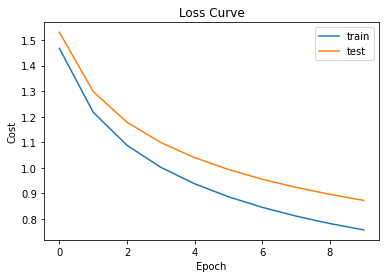

In [65]:
plt.plot(np.arange(epochs), train_cost)
plt.plot(np.arange(epochs), test_cost)
plt.legend(['train', 'test'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Loss Curve')
plt.show()


### Here is the Loss Curve. This curve shows how the cost is affected as the amount of time/experience the network has increases. The training curve is less than the test curve which is expected. They are both decreasing, but beginning to level out, indicating that the training time is approaching its optimum.

#### In a separate notebook I implemented a this same algorithm without batch gradient descent. Not only does it take more than 3 times as long to train (while taking fewer steps) the accuracy is less than that with batch gradient descent.

## Part 8 - Testing the Model

### Now that a model has been generated, its accuracy must be determined against both the training set and the test set. Ideally, the training set should have higher accuracy than the test set since it was trained to fit the training data.

In [66]:
def prediction(X, W, b):
    """Calculate the predictions of the network"""
    """Input: 
            X: train/test dataset
            W: solved weights
            b: solved biases
            
       Returns:
            predictions: the predictions of the network"""
    
    # Run the dataset forward through the network.
    A1, Z1 = forward_propagation(W[1], b[1], X, activation='relu')
    A2, Z2 = forward_propagation(W[2], b[2], A1, activation='relu')
    A3, Z3 = forward_propagation(W[3], b[3], A2, activation='softmax')
    
    # Find the prediction (the index value of the max value in each column).
    pred = np.argmax(A3, axis=0)
    
    return pred
    
    

In [68]:
# Find the predictions of the model on the train and test set
train_predict = prediction(X_train, W_solved, b_solved)
test_predict = prediction(X_test, W_solved, b_solved)

In [69]:
# Determine how many of each set was accurate.
a = (train_predict == Y_train)
b = (test_predict == Y_test)
train_accuracy = np.sum(a) / len(Y_train)
test_accuracy = np.sum(b) / len(Y_test)
print(f'Training Set Accuracy is {train_accuracy*100:.2f} %')
print(f'Test Set Accuracy is {test_accuracy*100:.2f} %')


Training Set Accuracy is 71.77 %
Test Set Accuracy is 72.37 %


In [23]:
# Compare labels to their predictions.
label_and_prediction = np.zeros((10, 10), dtype=np.int16)

for i in range(len(Y_test)):
    label_and_prediction[Y_test[i], test_predict[i]] += 1

print(label_and_prediction)

[[ 792    6   40   15   12   26   11   33   12   33]
 [   0 1037   29    4    4   27    4    7   17    6]
 [  32   45  644   75   28   30   68   30   54   26]
 [   8   31   49  715   16   66   21   48   25   31]
 [  10   25   23   29  658   35   59   26   18   99]
 [  29   42   48  109   56  331   37   76  103   61]
 [  40   25   59    2   40   35  698   13   19   27]
 [  35   47   39   18   16    9   19  744   30   71]
 [  29   55   61   55   46   46   31   43  569   39]
 [  34   40   13   33  126   30   50  131   47  505]]


## Part 9 - Conclusions

### This was a great learning experience. First I prepared the dataset to be acceptable to a neural network. Then I created activation functions. Next came the forward and backward propgation functions along with the cross entropy function. Afterward it all came together to solve a neural network with many times better accuracy than random guessing!

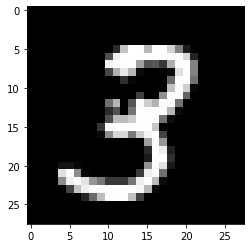

    This image is labeled as a "3"

    This image is predicted as a 3


In [24]:
# Look at an image from the test set, see its label and prediction.
ex_img = 5212
image = X_tst[ex_img]
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()
print(f'    This image is labeled as a "{Y_tst[ex_img]}"\n')
print(f'    This image is predicted as a {test_predict[ex_img]}')